In [251]:
from platform import python_version
python_version()

'3.9.17'

In [175]:
import sys
print(sys.executable)

/Users/laura/opt/anaconda3/envs/Tesina39/bin/python


In [47]:
#pip install -r requirement.txt
#pip install mlxtend
#pip install xgboost
#pip install pillow
#pip install fake_useragent
#pip install openpyxl
#pip install geopy
#pip install folium
#pip install selenium

<h1 style="font-family:Calibri;color:black;font-size:197%;text-align:center">The Art and Science of API Design: Crafting Connectivity in & out of Business </h1>

<h1 style="font-family:Calibri;color:black;font-size:117%;text-align:center">Master Data science - a.a. 2022-2023 
Final Project</h1>

<h1 style=";font-family:Calibri;color:violet;font-size:170%;text-align:center;border-radius: px 50px;"> student: Laura Proto </h1>

<h1 style="background-color:#eaeaea;font-family:Calibri;color:#fe0b50;font-size:200%;text-align:center;border-radius: 50px;padding: 10px">Parte pratica: Airlines Data</h1>

In [184]:
from PIL import Image
from IPython.display import display, HTML

display(HTML("<div style='display:flex; justify-content:center;'><img src='aircrafts.jpg' style='max-width:70%;'></div>"))

<h1 style="background-color:#eaeaea;font-family:Calibri;color:#ffcc00;font-size:250%;text-align:center;border-radius:50px;padding:10px 30px;">Index</h1>

- [Libraries & Utilities](#1)

- [Skyscanner.it](#2)
    - [Take airlines list from site](#2.1)
    - [Create df Skyscanner](#2.2)
- [Airfleets.net](#3)
    - [Take data from site](#3.1)
    - [Create df Airfleets](#3.2)
- [Merge Skyscanner.it & Airfleets.net data](#4)    
    - [Check results](#4.1)
- [Df Airfleets analisys](#5)    
    - [Test GET Airline info](#5.1)
    - [Test GET Airline info by country](#5.2)
    - [Test GET Airlines Summary By Country](#5.3)
    - [Creation of an html map for API](#5.4)
    - [Graphs](#5.5)

<a id = '1'></a>
<h1 style="background-color:#eaeaea;font-family:Calibri;color:#666699;font-size:250%;text-align:center;border-radius:50px;padding:10px 30px;">Libraries</h1>

In [1]:
import utils as ut

import requests
import time
import random
import json
import pandas as pd
import pickle
import re
import folium
import matplotlib.pyplot as plt
import os
import time

from bs4 import BeautifulSoup
from urllib.request import urlopen
from fake_useragent import UserAgent 
from datetime import date
from geopy.geocoders import Nominatim
from selenium import webdriver #modalità endless?? non apre la pagina

import warnings
warnings.filterwarnings('ignore')

<a id = '2'></a>
<h1 style="background-color:#eaeaea;font-family:Calibri;color:#0066ff;font-size:250%;text-align:center;border-radius: 50px;padding:10px 30px">Skyscanner.it</h1>

<a id = '2.1'></a>
<h1 style="font-size: 150%;">Take arlines list from site </h1>

In [101]:
ua = UserAgent()
ua.random

airlines = []

#search for href tags stored in soup
for page in range(1,999):
    grow = 0
    url_al= 'https://www.skyscanner.it/sitemap/voli-tutte-le-compagnie-aeree?page={}'.format(page)
    print(url_al)
    #request downloads the url and has options to pass additional info, such as the user agent
    data = requests.get(url_al, headers = {'User-Agent':'{}'.format(ua.random)})
    #use bs4 to parse html tags
    soup = BeautifulSoup(data.content, 'html.parser')
    for a in soup.find_all('a', href=True):
        #returns all links, filters on (a.get('href') only airlines  
        if 'linea-aerea' in a.get('href'):
            #print("{}".format(a.text) )
            #print("Found the URL:{}\n{}".format(a.get('href'),a.text) )
            #print("{}".format(a.text) )
            airlines.append(a.text.replace('Voli ',''))
            grow = 1
    if grow == 0:
        break

print("\n",len(airlines),"Airlines found")

#MUST BE 1406 Airlines

https://www.skyscanner.it/sitemap/voli-tutte-le-compagnie-aeree?page=1
https://www.skyscanner.it/sitemap/voli-tutte-le-compagnie-aeree?page=2
https://www.skyscanner.it/sitemap/voli-tutte-le-compagnie-aeree?page=3

 1406 Airlines found


<a id = '2.2'></a>
<h1 style="font-size: 150%;">Create df Skyscanner </h1>

In [102]:
heading = ['AIRLINE']

#create df 
df_sky = pd.DataFrame(columns=heading)

#adds rows in airlines to df_sky only if the rows are not empty
for r in airlines:
    if len(r)!=0:
        df_sky.loc[len(df_sky)] = r
        
df_sky_sorted = df_sky.sort_values(by='AIRLINE')
df_sky_sorted.head(3)

,AIRLINE
95,40-Mile Air
664,748 Air Services
234,9 Air


In [103]:
#count values
print("Website skyscanner.it:")

ut.count(df_sky_sorted)

#must be:
#- Airlines total: 1406
#- Unique row: 1387
#- Duplicate rows: 19

Website skyscanner.it:
- Airlines total: 1406
- Unique rows: 1387
- Duplicate rows: 19


In [105]:
#remove duplicates and export to excel
df_sky_no_duplicates = df_sky_sorted.drop_duplicates()

df_sky_no_duplicates.to_excel("outputs/df_skyscanners_1.xlsx", index=False)

<a id = '3'></a>
<h1 style="background-color:#eaeaea;font-family:Calibri;color:green;font-size:250%;text-align:center;border-radius: 50px;padding:10px 30px">Airfleets.net</h1>

<a id = '3.1'></a>
<h1 style="font-size: 150%;">Take data from site </h1>

In [88]:
#create random headers
list_headers = [{'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'},{"User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36"},{'User-Agent': 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/535.1 (KHTML, like Gecko) Chrome/13.0.782.41 Safari/535.1'}]
headers = random.choice(list_headers)
ua = UserAgent()

In [89]:
#ping site web
ua = UserAgent()

#recall def from utils.py
headers = ut.gen_random_headers()
url = 'https://www.airfleets.net/recherche/list-airline-a.htm'
data = requests.get(url, headers=headers)

if data.status_code == 200:
    print(f"Good Job!: {data}")
else:
     print(f"Ooopss :( {data} \n429 too many request \n403 forbidden")

Good Job!: <Response [200]>


In [90]:
#recall def from utils.py for dowload data
print(ut.listAlphabet())

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [91]:
ut.get_num_pages(url) #def must be here!
alphabet = ut.listAlphabet()
rows = []
row_names = []

<Response [200]>
<a class="page2">Page 1/45 </a>


In [94]:
#recall def from utils.py for create lowercase alphabet 
#(*need more runs for captcha or error request bypassed with VPN*)

#WARNING!!! This code don't download in every run the same number of data

while(len(alphabet) > 0):
    
    print('https://www.airfleets.net/recherche/list-airline-{}.htm'.format(alphabet[0]))
    num_pagine = ut.get_num_pages('https://www.airfleets.net/recherche/list-airline-{}.htm'.format(alphabet[0]))
    print(num_pagine)
    num_pagine = num_pagine.split('/')[1]
    
    for pagina in range(1,int(num_pagine)+1):
        url =''
        if pagina == 1:
            url = 'https://www.airfleets.net/recherche/list-airline-{}_0.htm'.format(alphabet[0])
        else:
            url = 'https://www.airfleets.net/recherche/list-airline-{}_{}.htm'.format(alphabet[0],(pagina-1)*20)
        data = requests.get( url,headers = {'User-Agent':'{}'.format(ua.random)})
        soup = BeautifulSoup(data.content, 'html.parser')
        print('fetch indirizzo {} {}'.format(url,data))
        
        for table in soup.find_all("table", class_="tablestd"):
            for row in table.find_all("tr", class_="tabcontent"):
                for colonna in row.find_all("td"):
                    row_names.append(colonna.text)
                    #print(row_names)
                #print('fine row')

                rows.append(row_names)
                row_names = []
        #time.sleep(1)
    print('Delete letter {}'.format(alphabet[0]))
    alphabet.pop(0)
                                                                
                                                                                                                  
print("\nAll letters have been taken!")

https://www.airfleets.net/recherche/list-airline-i.htm
<Response [200]>
<a class="page2">Page 1/6 </a>
Page 1/6 
fetch indirizzo https://www.airfleets.net/recherche/list-airline-i_0.htm <Response [200]>
fetch indirizzo https://www.airfleets.net/recherche/list-airline-i_20.htm <Response [200]>
fetch indirizzo https://www.airfleets.net/recherche/list-airline-i_40.htm <Response [200]>
fetch indirizzo https://www.airfleets.net/recherche/list-airline-i_60.htm <Response [200]>
fetch indirizzo https://www.airfleets.net/recherche/list-airline-i_80.htm <Response [200]>
fetch indirizzo https://www.airfleets.net/recherche/list-airline-i_100.htm <Response [200]>
Delete letter i
https://www.airfleets.net/recherche/list-airline-j.htm
<Response [200]>
<a class="page2">Page 1/6 </a>
Page 1/6 
fetch indirizzo https://www.airfleets.net/recherche/list-airline-j_0.htm <Response [200]>
fetch indirizzo https://www.airfleets.net/recherche/list-airline-j_20.htm <Response [200]>
fetch indirizzo https://www.air

fetch indirizzo https://www.airfleets.net/recherche/list-airline-s_240.htm <Response [200]>
fetch indirizzo https://www.airfleets.net/recherche/list-airline-s_260.htm <Response [200]>
fetch indirizzo https://www.airfleets.net/recherche/list-airline-s_280.htm <Response [200]>
fetch indirizzo https://www.airfleets.net/recherche/list-airline-s_300.htm <Response [200]>
fetch indirizzo https://www.airfleets.net/recherche/list-airline-s_320.htm <Response [200]>
fetch indirizzo https://www.airfleets.net/recherche/list-airline-s_340.htm <Response [200]>
fetch indirizzo https://www.airfleets.net/recherche/list-airline-s_360.htm <Response [200]>
fetch indirizzo https://www.airfleets.net/recherche/list-airline-s_380.htm <Response [200]>
fetch indirizzo https://www.airfleets.net/recherche/list-airline-s_400.htm <Response [200]>
Delete letter s
https://www.airfleets.net/recherche/list-airline-t.htm
<Response [200]>
<a class="page2">Page 1/12 </a>
Page 1/12 
fetch indirizzo https://www.airfleets.net

In [95]:
len(rows)
#WARNING!!!Better if they are  =>7611 otherwise you have to relaunch the extraction

7611

In [96]:
#create pkl file

output_directory = 'outputs/'
today = date.today()
tosave = [rows]

filename = 'saved_{}.pkl'.format(today)

with open(output_directory + filename, 'wb') as file:
    # A new file will be created
    pickle.dump(tosave, file)
    
with open(output_directory + filename, 'rb') as file:
    tosave = pickle.load(file)
file.close()

<a id = '3.2'></a>
<h1 style="font-size: 150%;">Create df Airfleets </h1>

In [97]:
#create df airfleets
len(rows)
heading = ['AIRLINE','IMgG','COUNTRY','INFORMATION/N.AIRCRAFT']
df_af = pd.DataFrame(columns=heading)
for r in rows:
    if len(r)!=0:
        r = [el.replace('\n','') for el in  r]
        df_af.loc[len(df_af)] = r

#delete coloumn ImgG
df_af = df_af.drop(columns=['IMgG']) 

#delete empty space before and after string
df_af[['INFORMATION/N.AIRCRAFT', 'COUNTRY', 'AIRLINE']] = df_af[['INFORMATION/N.AIRCRAFT', 'COUNTRY', 'AIRLINE']].applymap(str.strip)

#def to delete the word "aircraft" from row with a number (es: '3 aircraft')
def remove_aircraft(text):
    if re.match(r'\d+\s+aircraft', text):
        return re.sub(r'\s*aircraft', '', text)
    else:
        return text
    
#appliad def to 'INFORMATION/N.AIRCRAFT' coloumn
df_af['INFORMATION/N.AIRCRAFT'] = df_af['INFORMATION/N.AIRCRAFT'].apply(remove_aircraft)

df_af.head()

,AIRLINE,COUNTRY,INFORMATION/N.AIRCRAFT
0,AB Airlines,United Kingdom,inactive (with supported aircraft)
1,Aba Air,Czech Republic,inactive (with supported aircraft)
2,ABC Air Hungary,Hungary,inactive (with supported aircraft)
3,Abelag Airways,Belgium,inactive (with supported aircraft)
4,ABS Jets,Czech Republic,4


In [98]:
#count values
print("Website airfleets.net:")

ut.count(df_af)

#- Airlines total: 7611 
#- Unique row MUST BE: 4080 otherwise you have to relaunch the extraction
#- Duplicates rows: 3531

Website airfleets.net:
- Airlines total: 7611
- Unique rows: 4080
- Duplicate rows: 3531


In [106]:
#delete duplicates and export to excel clean file
df_no_duplicates = df_af.drop_duplicates()

df_no_duplicates.to_excel("outputs/df_airfleets_1.xlsx", index=False)

In [108]:
#read file
df_af_ex = pd.read_excel('outputs/df_airfleets_1.xlsx')
df_af_ex.head(7)

,AIRLINE,COUNTRY,INFORMATION/N.AIRCRAFT
0,AB Airlines,United Kingdom,inactive (with supported aircraft)
1,Aba Air,Czech Republic,inactive (with supported aircraft)
2,ABC Air Hungary,Hungary,inactive (with supported aircraft)
3,Abelag Airways,Belgium,inactive (with supported aircraft)
4,ABS Jets,Czech Republic,4
5,ABSA Cargo,Brazil,inactive (with supported aircraft)Renamed / Me...
6,Abu Dhabi Amiri Flight,United Arab Emirates,5


In [110]:
#clean data in colunmm 'INFORMATION/N.AIRCRAFT'
print('Number of lines in INFORMATION/N.AIRCRAFT that:')

# - contain only a number without spaces
count_rows_with_number = df_af_ex['INFORMATION/N.AIRCRAFT'].str.contains(r'^\d+$').sum()
print(f"- Contain only the number of aircraft:': {count_rows_with_number}")

# - contain a number + ' Renamed / Merged to '
count_rows_matching_pattern = df_af_ex['INFORMATION/N.AIRCRAFT'].str.contains(r'^\d+\s+Renamed / Merged to ').sum()
print(f"- Starts with a number + 'Renamed / Merged to': {count_rows_matching_pattern}")

# - contain the phrase 'inactive (with supported aircraft)'
count_inactive_rows = (df_af_ex['INFORMATION/N.AIRCRAFT'] == 'inactive (with supported aircraft)').sum()
print(f"- Contain 'inactive (with supported aircraft)': {count_inactive_rows}")

# - starts with the phase'inactive (with supported aircraft)Renamed / Merged to '
count_rows_start_with_inactive = df_af_ex[df_af_ex['INFORMATION/N.AIRCRAFT'].str.startswith('inactive (with supported aircraft)Renamed / Merged to ')].shape[0]
print(f"- Starts with 'inactive (with supported aircraft)Renamed / Merged to ': {count_rows_start_with_inactive}")

df_af_ex.head(7)

#- Contain only the number of aircraft': 1274
#- Starts with a number + 'Renamed / Merged to': 7
#- Contain 'inactive (with supported aircraft)': 2149
#- Starts with 'inactive (with supported aircraft)Renamed / Merged to ': 605

Number of lines in INFORMATION/N.AIRCRAFT that:
- Contain only the number of aircraft:': 1274
- Starts with a number + 'Renamed / Merged to': 7
- Contain 'inactive (with supported aircraft)': 2194
- Starts with 'inactive (with supported aircraft)Renamed / Merged to ': 605


,AIRLINE,COUNTRY,INFORMATION/N.AIRCRAFT
0,AB Airlines,United Kingdom,inactive (with supported aircraft)
1,Aba Air,Czech Republic,inactive (with supported aircraft)
2,ABC Air Hungary,Hungary,inactive (with supported aircraft)
3,Abelag Airways,Belgium,inactive (with supported aircraft)
4,ABS Jets,Czech Republic,4
5,ABSA Cargo,Brazil,inactive (with supported aircraft)Renamed / Me...
6,Abu Dhabi Amiri Flight,United Arab Emirates,5


In [117]:
#to simplify, the 7 airlines whose aircraft 
#have been renamed and assimilated into new companies 


#find the rows starting with 'number Renamed / Merged to'.
mask = df_af_ex['INFORMATION/N.AIRCRAFT'].str.contains(r'^\d+\s+Renamed / Merged to')

#substituting the values with 'inactive (with supported aircraft)'and re-counting
df_af_ex.loc[mask, 'INFORMATION/N.AIRCRAFT'] = 'inactive (with supported aircraft)'

print('Number of lines in INFORMATION/N.AIRCRAFT that:')
count_inactive_rows = (df_af_ex['INFORMATION/N.AIRCRAFT'] == 'inactive (with supported aircraft)').sum()
print(f"\n- Containing 'inactive (with supported aircraft)' NOW should be 2201: {count_inactive_rows}")

df_af_ex.head()

Number of lines in INFORMATION/N.AIRCRAFT that:

- Containing 'inactive (with supported aircraft)' NOW should be 2201: 2201


,AIRLINE,COUNTRY,INFORMATION/N.AIRCRAFT
0,AB Airlines,United Kingdom,inactive (with supported aircraft)
1,Aba Air,Czech Republic,inactive (with supported aircraft)
2,ABC Air Hungary,Hungary,inactive (with supported aircraft)
3,Abelag Airways,Belgium,inactive (with supported aircraft)
4,ABS Jets,Czech Republic,4


In [118]:
#export to excel clean file for my api
df_af_ex.to_excel('outputs/df_airfleets_clean_2.xlsx', index=False)
df_af_ex.to_json('df_airfleets_clean.json', index=False) #DON'T change his position!!!

#------------------------------------------------------------------------------

<a id = '4'></a>
<h1 style="background-color:#eaeaea;font-family:Calibri;color:#9933ff;font-size:250%;text-align:center;border-radius: 50px;padding:10px 30px">Merge Skyscanner.it & Airfleets.net data </h1>

### Data cleaning

In [119]:
#clean airlines Skyscanner
df_sky = pd.read_excel('outputs/df_skyscanners_1.xlsx')

#recall def from utils.py for clean column value
ut.clean_column(df_sky, 'AIRLINE')

#recall def from utils.py for delete column duplicates
cleaned_df_sky = ut.process_column(df_sky, 'AIRLINE')

print("\nNow the df has:", len(cleaned_df_sky), "rows - (originally 1387)")

#should be 6

Duplicates found: 6
          AIRLINE
207       airlink
209      airnorth
485   eastafrican
1134   smartwings
1312      vivaair
1348    world2fly

Now the df has: 1381 rows - (originally 1387)


In [121]:
#clean airfleets data
df_af = pd.read_excel('outputs/df_airfleets_clean_2.xlsx')

#duplicates the entire df
df_af['AIRLINE_copy'] = df_af['AIRLINE'].copy()
df_af['COUNTRY_copy'] = df_af['COUNTRY'].copy()
df_af['INFORMATION/N.AIRCRAFT_copy'] = df_af['INFORMATION/N.AIRCRAFT'].copy()

#recall def from utils.py for clean column value (only for one column)
ut.clean_column(df_af, 'AIRLINE')

#recall def from utils.py for delete column duplicates
cleaned_df_af = ut.process_column(df_af,['AIRLINE', 'COUNTRY', 'INFORMATION/N.AIRCRAFT'])

print("\nNow the df has:", len(cleaned_df_af), "rows - (originally 4080)")

#should be 2

Duplicates found: 2
          AIRLINE  COUNTRY              INFORMATION/N.AIRCRAFT AIRLINE_copy  \
1828  germanwings  Germany  inactive (with supported aircraft)  Germanwings   
3522    sultanair   Turkey  inactive (with supported aircraft)    Sultanair   

     COUNTRY_copy         INFORMATION/N.AIRCRAFT_copy  
1828      Germany  inactive (with supported aircraft)  
3522       Turkey  inactive (with supported aircraft)  

Now the df has: 4078 rows - (originally 4080)


### Merge dataframes

In [123]:
#merge both df
res_merge_df = pd.merge(cleaned_df_af, cleaned_df_sky, on='AIRLINE', how='inner')
#counts value for discard value = 0
count_airlines = res_merge_df['AIRLINE'].value_counts()
companies_with_more_than_1_occurrence = count_airlines[count_airlines >= 1]
print("Companies with more than 1 occurrence:")
print(companies_with_more_than_1_occurrence)

#should be 853

Companies with more than 1 occurrence:
AIRLINE
skyexpress         2
jetstar            2
swiftair           2
tianjinairlines    2
easternairlines    2
                  ..
dalianairlines     1
danair             1
danaair            1
dat                1
zambiaairways      1
Name: count, Length: 853, dtype: int64


In [124]:
#deleted modified columns for came back original values
res_merge_df.drop(columns=['AIRLINE', 'COUNTRY', 'INFORMATION/N.AIRCRAFT'], inplace=True)
#rename the copied columns by deleting '_copy'
res_merge_df.rename(columns={'AIRLINE_copy': 'AIRLINE', 'COUNTRY_copy': 'COUNTRY', 'INFORMATION/N.AIRCRAFT_copy': 'INFORMATION/N.AIRCRAFT'}, inplace=True)
print(res_merge_df)

              AIRLINE      COUNTRY              INFORMATION/N.AIRCRAFT
0     Aegean Airlines       Greece                                  60
1          Aer Lingus      Ireland                                  55
2      Aero Caribbean         Cuba                                   2
3    Aero Contractors      Nigeria  inactive (with supported aircraft)
4           Aero Dili  Timor-Leste                                   1
..                ...          ...                                 ...
859     Yeti Airlines        Nepal                                   5
860   Zagros Airlines         Iran                                  12
861         Zagrosjet         Iraq  inactive (with supported aircraft)
862  Zambezi Airlines       Zambia  inactive (with supported aircraft)
863    Zambia Airways       Zambia                                   1

[864 rows x 3 columns]


In [125]:
#save merge on excel
res_merge_df.to_excel('outputs/res_merge_df_3.xlsx', index=False)

### Extract 10 random values (5 active + 5 inactive)

In [227]:
#extract 5 random rows from df_active
df_active = res_merge_df[res_merge_df['INFORMATION/N.AIRCRAFT'].str.contains(r'\d', regex=True)]

#the random_state parameter if specified extracts the same values in successive executions
df_random_a  = df_active.sample(n=5, random_state=20) 
#print(df_random_a)    

In [268]:
df_random_a['MANUAL CHECK'] = ''
df_random_a.at[df_random_a.index[0], 'MANUAL CHECK'] = 'Active'
df_random_a.at[df_random_a.index[1], 'MANUAL CHECK'] = 'Active'
df_random_a.at[df_random_a.index[2], 'MANUAL CHECK'] = 'Active'
df_random_a.at[df_random_a.index[3], 'MANUAL CHECK'] = 'Active'
df_random_a.at[df_random_a.index[4], 'MANUAL CHECK'] = 'Active'
df_random_a

,AIRLINE,COUNTRY,INFORMATION/N.AIRCRAFT,MANUAL CHECK
17,AeroUnion,Mexico,5,Active
614,PassionAir,Ghana,4,Active
768,Thai Lion Air,Thailand,15,Active
15,Aeropostal,Venezuela,1,Active
534,Mandarin Airlines,Taiwan,9,Active


In [231]:
#extract 5 random rows from df_inactive
df_inactive = res_merge_df[res_merge_df['INFORMATION/N.AIRCRAFT'].str.contains('inactive')]

#the random_state parameter if specified extracts the same values in successive executions
df_random_b = df_inactive.sample(n=5, random_state=42)  

#print(df_random_a.to_string(index=False))   

In [267]:
df_random_b['MANUAL CHECK'] = ''
df_random_b.at[df_random_b.index[0], 'MANUAL CHECK'] = 'Back in service after suspension'
df_random_b.at[df_random_b.index[1], 'MANUAL CHECK'] = 'Absorbed/changed name'
df_random_b.at[df_random_b.index[2], 'MANUAL CHECK'] = 'Absorbed/changed name'
df_random_b.at[df_random_b.index[3], 'MANUAL CHECK'] = 'Active'
df_random_b.at[df_random_b.index[4], 'MANUAL CHECK'] = 'Inactive'

#print(df_random_b.to_string(index=False))
#columns_to_display = ['AIRLINE', 'COUNTRY', 'MANUAL CHECK']
#print(df_random_b[columns_to_display].to_string(index=False))
df_random_b

,AIRLINE,COUNTRY,INFORMATION/N.AIRCRAFT,MANUAL CHECK
290,Dana Air,Nigeria,inactive (with supported aircraft),Back in service after suspension
754,TACA Peru,Peru,inactive (with supported aircraft)Renamed / Me...,Absorbed/changed name
672,Seaborne Airlines,USA,inactive (with supported aircraft),Absorbed/changed name
59,Air Georgia,Georgia,inactive (with supported aircraft),Active
476,Kabo Air,Nigeria,inactive (with supported aircraft),Inactive


<a id = '4.1'></a>
<h1 style="font-size: 150%;">Check results </h1>

Considering the difficulty in finding an up-to-date list of active airlines, we examined Skyscanner, known for selling flights, as a possible reliable source. However, we found that out of 1381 supposedly active airlines, only 864 were actually listed in Airfleet's data.

A subsequent analysis revealed that not even all of the companies listed on Skyscanner were active, leading us to carry out tests. Therefore, 10 airlines were randomly drawn, of which 5 were considered active and 5 inactive according to Airfleet, and a spot check was carried out online.

The results showed that the 5 companies considered active by both sites were indeed in service. However, of the 5 airlines classified as inactive by Airfleet (but initially considered active based on the assumption that Skyscanner had up-to-date data), only 2 were actually operating. This raised doubts about the completeness of the information provided by Skyscanner regarding active airlines.

<font size="4"> Considering the results: api will use data from the </font> <font size="4" color=magenta ><b> df Airfleets </font>

#------------------------------------------------------------------------------

<a id = '5'></a>
<h1 style="background-color:#eaeaea;font-family:Calibri;color:dark;font-size:250%;text-align:center;border-radius: 50px;padding:10px 30px">Df Airfleets analisys</h1>

In [146]:
df_af_clean = pd.read_excel('outputs/df_airfleets_clean_2.xlsx')
df_af_clean.head()

,AIRLINE,COUNTRY,INFORMATION/N.AIRCRAFT
0,AB Airlines,United Kingdom,inactive (with supported aircraft)
1,Aba Air,Czech Republic,inactive (with supported aircraft)
2,ABC Air Hungary,Hungary,inactive (with supported aircraft)
3,Abelag Airways,Belgium,inactive (with supported aircraft)
4,ABS Jets,Czech Republic,4


### Count airlines & countries 

In [148]:
num_unique_airlines = df_af_clean['AIRLINE'].nunique()
num_unique_countries = df_af_clean['COUNTRY'].nunique()
print(f"Dataset Airfleets have {num_unique_airlines} Airlines in {num_unique_countries} countries")

#should be 4080 Airlines in 196 countries

Dataset Airfleets have 4080 Airlines in 196 countries


<a id = '5.1'></a>
<h1 style="font-size: 150%;">Test GET Airline info </h1>

In [181]:
#entering a Airline name provides list with informations

airline_name = input("Insert airline name to get its information: ").capitalize() 

#removes spaces from the airline name
airline_name = airline_name.replace(" ", "").lower()

#flag to check whether the country has been found
finded = False  

#search for the airline (converting existing names to lower case and removing spaces)
for index, existing_airline in df_af_clean['AIRLINE'].items():
    if existing_airline.replace(" ", "").lower() == airline_name:
        country = df_af_clean['COUNTRY'][index]
        information = df_af_clean['INFORMATION/N.AIRCRAFT'][index]
        if information.strip() == "":
            print("Attention! The airline name is blank")
        else:
            print(f"Airline name: {existing_airline}")
            print(f"Country: {country}")
            print(f"Information/Number of aircraft: {information}")
        trovata = True
        break

#Check if the airline was found
if not finded:
    print(f"No airline found for the name '{airline_name}'")

Insert airline name to get its information: air france
Airline name: Air France
Country: France
Information/Number of aircraft: 214
No airline found for the name 'airfrance'


<a id = '5.2'></a>
<h1 style="font-size: 150%;">Test GET Airline info by country</h1>

In [251]:
#entering a country provides list of airlines and their data

country = input("Insert country name to have the list of airlines and their data: ").capitalize() 

#flag to check whether the country has been found
finded = False  

#initialise a list to store airlines and related data
airlines_f = []
num = 0

#search the country
for index, row in df_af_clean.iterrows():
    if row['COUNTRY'].lower() == country.lower():
        finded = True
        airline = {
            'AIRLINE': row['AIRLINE'],
            'COUNTRY': row['COUNTRY'],
            'INFORMATION/N.AIRCRAFT': row['INFORMATION/N.AIRCRAFT']
        }
        airlines_f.append(airline)
        num +=1

#check if the country has been found
if finded:
    print(f"\nNumber of airlines found: {num}")
    for company in airlines_f:
        print(f"\nAirline name: {company['AIRLINE']}")
        print(f"Country: {company['COUNTRY']}")
        print(f"Number of aircraft or info: {company['INFORMATION/N.AIRCRAFT']}")
        print("-" * 20)
        
else:
    print(f"No airline found for the country {country}")


Insert country name to have the list of airlines and their data: italy

Number of airlines found: 73

Airline name: Aeroitalia
Country: Italy
Number of aircraft or info: 9
--------------------

Airline name: Air Bee
Country: Italy
Number of aircraft or info: inactive (with supported aircraft)
--------------------

Airline name: Air Dolomiti
Country: Italy
Number of aircraft or info: 19
--------------------

Airline name: Air Europe Italy
Country: Italy
Number of aircraft or info: inactive (with supported aircraft)
--------------------

Airline name: Air Industria
Country: Italy
Number of aircraft or info: inactive (with supported aircraft)
--------------------

Airline name: Air Italy
Country: Italy
Number of aircraft or info: inactive (with supported aircraft)Renamed / Merged to Meridiana
--------------------

Airline name: Air One
Country: Italy
Number of aircraft or info: inactive (with supported aircraft)Renamed / Merged to Alitalia
--------------------

Airline name: Air One CityL

In [257]:
#for save list
df_italy = pd.DataFrame(airlines_f)
df_italy.to_excel('outputs/airlines_Italy.xlsx', index=False)

<a id = '5.3'></a>
<h1 style="font-size: 150%;">Test GET Airlines Summary By Country</h1>

In [158]:
#entering a country provides numbers of active, disappeared, absorbed airlines

country = input("Insert country name to have the summary of airlines: ").capitalize() 

findend_c = False  # Flag per verificare se il paese è stato trovato

active_count = 0
disappeared_count = 0
absorbed_count = 0

#ciclo for per cercare il paese
for index, row in df_af_clean.iterrows():
    if row['COUNTRY'].lower() == country.lower():  #ignora maiuscole/minuscole
        findend_c = True
        information = row['INFORMATION/N.AIRCRAFT']

        if information.isdigit():  #controllo se è un numero (compagnia attiva)
            active_count += 1
        elif information == 'inactive (with supported aircraft)':  #compagnia scomparsa
            disappeared_count += 1
        elif information.startswith('inactive (with supported aircraft)Renamed / Merged to'):  #compagnia assorbita
            absorbed_count += 1

#verifica se il paese è stato trovato
if findend_c:
    print(f"Number of active companies: {active_count}")
    print(f"Number of companies disappeared: {disappeared_count}")
    print(f"Number of companies absorbed: {absorbed_count}")
else:
    print("Error: country not found")


Insert country name to have the summary of airlines: italy
Number of active companies: 8
Number of companies disappea: 53
Number of companies absorbed: 12


<a id = '5.4'></a>
<h1 style="font-size: 150%;">Map1 - Creation of an html map for API</h1>

In [163]:
#MAP 1 (*sometimes nedd more run for error request*)

m = folium.Map(location=[0, 0], zoom_start=2)

#creation of a geolocation object
geolocator = Nominatim(user_agent="country_locator")

#created unique country value
country_unique = df_af_clean['COUNTRY'].unique()
#len(country_unique)  #must be 196

#list for storing geographical coordinates of countr
coordinates_list = []

for country in country_unique:
    #get geographical coordinates of the country
    location = geolocator.geocode(country)

    #added markers on the map with the name of the country and stored coordinates
    if location:
        coordinates = [location.latitude, location.longitude]
        coordinates_list.append(coordinates)
        folium.Marker(
            location=coordinates,
            popup=country,
        ).add_to(m)

#save map to HTML file
m.save('outputs/world_map.html') #don't change name!

#export to Excel the coordinates
df_coor = pd.DataFrame(coordinates_list, columns=["Latitude", "Longitude"])
df_coor.to_excel('outputs/coordinates_country_5.xlsx', index=False)

<a id = '5.4'></a>
<h1 style="font-size: 150%;">Map 2 - Creating a png map for inclusion in the thesis</h1>

In [166]:
#MAP 2 

m = folium.Map(location=[0, 0], zoom_start=2)
for coordinates in coordinates_list:
    lat, lon = coordinates
    folium.Marker(
        location=[lat, lon],
        icon=folium.Icon(icon="flag"),  #changed icon in flag
    ).add_to(m)

#show map
m

In [183]:
#NON-interactive map

#find the directory in which to save the map
map_path = os.path.abspath("world_map.html")

#Firefox driver instance creation
driver = webdriver.Firefox()

#customised browser window size
driver.set_window_size(1100, 700) #1920, 1080

#open map HTML files from directory 
driver.get("file://" + map_path)

#wait 5 secondi, useful because before the shot you can move/resize the map
time.sleep(5)

#screenshot + save
driver.save_screenshot('outputs/map_screenshot_6_.png') 
#added "_" for don't overwrite and avoid manual positioning screenshot

driver.quit()

<a id = '5.5'></a>
<h1 style="font-size: 150%;">Graphs</h1>

In [170]:
#Created new_df 
df_af_clean = pd.read_excel('outputs/df_airfleets_clean_2.xlsx')

active_count = 0
disappeared_count = 0
absorbed_count = 0

grouped = df_af_clean.groupby('COUNTRY')

results = []

for country, group in grouped:
    active_sum = (group['INFORMATION/N.AIRCRAFT'].str.isdigit()).sum()
    disappeared_sum = (group['INFORMATION/N.AIRCRAFT'] == 'inactive (with supported aircraft)').sum()
    absorbed_sum = (group['INFORMATION/N.AIRCRAFT'].str.startswith('inactive (with supported aircraft)Renamed / Merged to')).sum()
    others = disappeared_sum + absorbed_sum 
    tot = others + active_sum
    results.append({'COUNTRY': country,'Tot': tot, 'Airline active': active_sum, 'Airline disappeared': others})

result_df = pd.DataFrame(results)

result_df.head()

,COUNTRY,Tot,Airline active,Airline disappeared
0,Afghanistan,7,2,5
1,Albania,8,2,6
2,Algeria,10,4,6
3,Angola,16,6,10
4,Antigua Barbuda,6,1,5


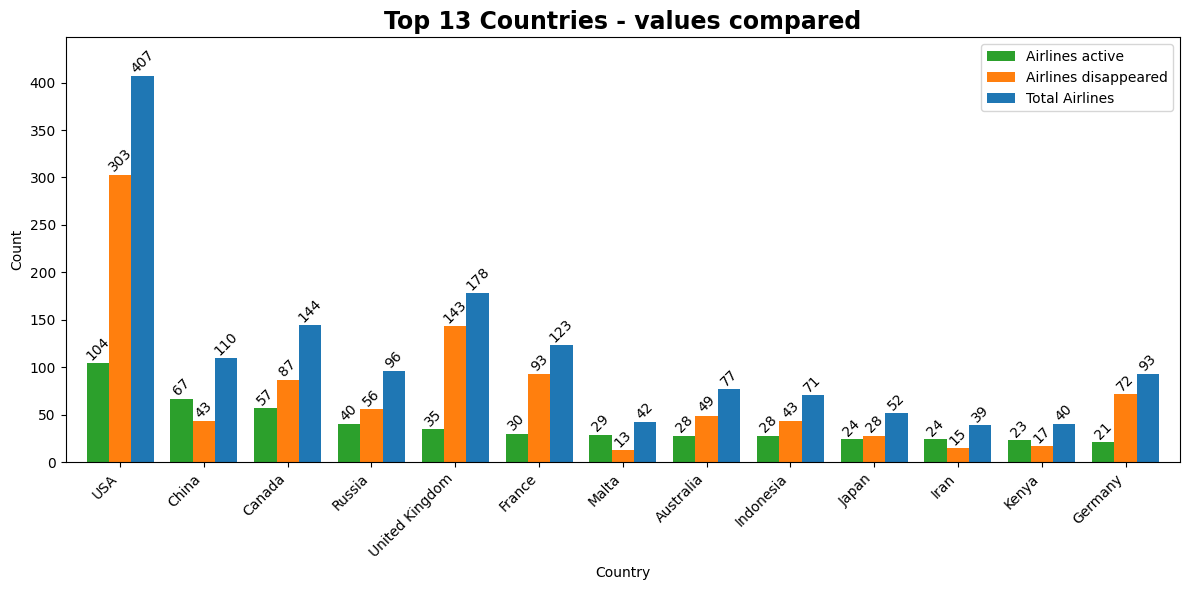

In [248]:
#Chart Top 13 Countries - values compared

#df active companies in descending order
result_df = result_df.sort_values(by='Airline active', ascending=False)
top_df = result_df.head(13)

#take data from df
x = top_df['COUNTRY']
y1 = top_df['Airline active']
y2 = top_df['Airline disappeared']
y3 = top_df['Tot']

fig, ax = plt.subplots(figsize=(12, 6))

ax = top_df.plot(kind='bar', x='COUNTRY', y=['Airline active', 'Airline disappeared', 'Tot'],
                   width=0.8, color=['tab:green', 'tab:orange', 'tab:blue'], ax=ax)

#kind = chart tipe
#width = bar width 
#ax=ax = specifies the axis in which to insert the graph i.e. the one previously created with "fig, ax = ...""

ax.set_xlabel("Country")
ax.set_ylabel("Count")
ax.set_title("Top 13 Countries - values compared", fontsize=17, fontweight='bold')
ax.legend(["Airlines active", "Airlines disappeared", "Total Airlines"], loc="upper right")
ax.set_ylim(0, top_df['Tot'].max() * 1.1)  #upper limit y-axis
ax.set_xticklabels(x, rotation=45, ha='right')

#data above bars with 45 degree rotation
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', rotation=45)   
    
plt.tight_layout()
plt.savefig('outputs/Top 13 Countries - values compared_7.png')
plt.show()

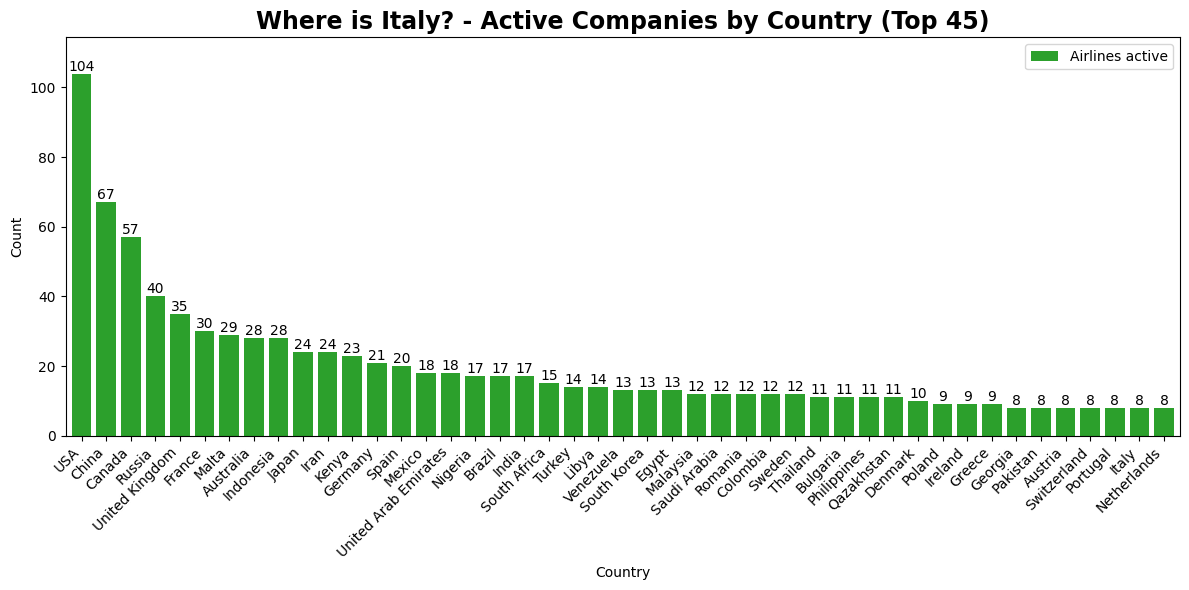

In [250]:
#Chart Active Companies by Country (Top 45) - Where is Italy?

#df for active companies in descending order
result_df = result_df.sort_values(by='Airline active', ascending=False)
top_a_df = result_df.head(45) #result_df.iloc[13:45]

#take data from df
x = top_a_df['COUNTRY']
y = top_a_df['Airline active']

fig, ax = plt.subplots(figsize=(12, 6))

ax = top_a_df.plot(kind='bar', x='COUNTRY', y=['Airline active'],
                   width=0.8, color=['tab:green'], ax=ax)
#kind = chart tipe
#width = bar width 
#ax=ax = specifies the axis in which to insert the graph i.e. the one previously created with "fig, ax = ...""

ax.set_xlabel("Country")
ax.set_ylabel("Count")
ax.set_title("Where is Italy? - Active Companies by Country (Top 45)", fontsize=17, fontweight='bold')
ax.legend(["Airlines active"], loc="upper right")
ax.set_ylim(0, top_a_df['Airline active'].max() * 1.1)  #upper limit y-axis

#rotating country labels
ax.set_xticklabels(x, rotation=45, ha='right')

#data above bars with 45 degree rotation
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.savefig('outputs/Where is Italy?_8.png')
plt.show()

#------------------------------------------------------------------------------

#------------------------------------------------------------------------------

#------------------------------------------------------------------------------

### Are airlines actually active in italy?

In [272]:
df_italy = pd.read_excel('outputs/airlines_Italy.xlsx')
filtered_rows = df_italy[df_italy['INFORMATION/N.AIRCRAFT'].str.match(r'^\d+$')]
print('Airlines in Italy:')
print(filtered_rows)

Airlines in Italy:
                         AIRLINE COUNTRY INFORMATION/N.AIRCRAFT
0                     Aeroitalia   Italy                      9
2                   Air Dolomiti   Italy                     19
26               Cargolux Italia   Italy                      2
37  ITA - Italia Trasporto Aereo   Italy                     76
40             Italian Air Force   Italy                     17
56                          Neos   Italy                     15
59               Poste Air Cargo   Italy                      6
64                       SkyAlps   Italy                      5


In [274]:
filtered_rows['MANUAL CHECK'] = ''

filtered_rows.at[filtered_rows.index[0], 'MANUAL CHECK'] = 'test'
filtered_rows.at[filtered_rows.index[1], 'MANUAL CHECK'] = 'test'
filtered_rows.at[filtered_rows.index[2], 'MANUAL CHECK'] = 'test'
filtered_rows.at[filtered_rows.index[3], 'MANUAL CHECK'] = 'test'
filtered_rows.at[filtered_rows.index[4], 'MANUAL CHECK'] = 'test'
filtered_rows.at[filtered_rows.index[5], 'MANUAL CHECK'] = 'test'
filtered_rows.at[filtered_rows.index[6], 'MANUAL CHECK'] = 'test'
filtered_rows.at[filtered_rows.index[7], 'MANUAL CHECK'] = 'test'
filtered_rows

,AIRLINE,COUNTRY,INFORMATION/N.AIRCRAFT,MANUAL CHECK
0,Aeroitalia,Italy,9,test
2,Air Dolomiti,Italy,19,test
26,Cargolux Italia,Italy,2,test
37,ITA - Italia Trasporto Aereo,Italy,76,test
40,Italian Air Force,Italy,17,test
56,Neos,Italy,15,test
59,Poste Air Cargo,Italy,6,test
64,SkyAlps,Italy,5,test
